## reimbursement

In [ ]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

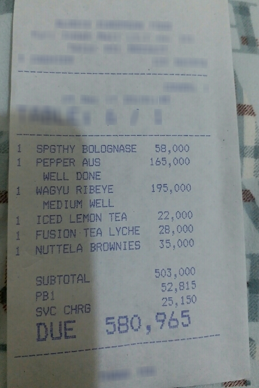

In [ ]:
example = dataset['train'][1]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [ ]:
ground_truth = example['ground_truth']
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'menu': [{'nm': 'SPGTHY BOLOGNASE', 'cnt': '1', 'price': '58,000'},
  {'nm': 'PEPPER AUS',
   'cnt': '1',
   'price': '165,000',
   'sub': {'nm': 'WELL DONE'}},
  {'nm': 'WAGYU RIBEYE',
   'cnt': '1',
   'price': '195,000',
   'sub': {'nm': 'MEDIUM WELL'}},
  {'nm': 'ICED LEMON TEA', 'cnt': '1', 'price': '22,000'},
  {'nm': 'FUSION TEA LYCHE', 'cnt': '1', 'price': '28,000'},
  {'nm': 'NUTTELA BROWNIES', 'cnt': '1', 'price': '35,000'}],
 'sub_total': {'subtotal_price': '503,000',
  'service_price': '25,150',
  'tax_price': '52,815'},
 'total': {'total_price': '580,965'}}

In [ ]:

from transformers import VisionEncoderDecoderConfig

image_size = [1280, 960]
max_length = 768

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    1280,
    960
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_v

In [ ]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    PyTorch Dataset for Donut. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into pixel_values (vectorized image) and labels (input_ids of the tokenized string).

    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"", fr""])
                    output += (
                        fr""
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr""
                    )
                return output
        elif type(obj) == list:
            return r"".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [ ]:

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="train", task_start_token="", prompt_end_token="",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("naver-clova-ix/cord-v2", max_length=max_length,
                             split="validation", task_start_token="", prompt_end_token="",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([''])[0]

In [ ]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
pip install pytorch_lightning

In [ ]:

from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)

        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [ ]:

config = {"max_epochs":30,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)

In [ ]:
b6dcd8071839fbf93719c20e535a1c608da29e41

NameError: name 'b6dcd8071839fbf93719c20e535a1c608da29e41' is not defined

In [ ]:

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping
wandb_logger = WandbLogger(project="Donut", name="demo-run-cord")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("nielsr/donut-demo",
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
)

trainer.fit(model_module)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: elintgyan2024 (elintgyan2024-elintdata-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M  | eval
-----------------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
807.408   Total estimated model params size (MB)
0         Modules in train mode
484       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.
Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.
Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new 

Validation: |          | 0/? [00:00<?, ?it/s]

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.
Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.
Keyword argument `random_padding` is not a valid argument for this processor and will be ignored.
Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new 

error: missing ), unterminated subpattern at position 12

In [ ]:
from donut import DonutModel
import torch
from PIL import Image


pretrained_model = DonutModel.from_pretrained("naver-clova-ix/donut-base",ignore_mismatched_sizes=True)
if torch.cuda.is_available():
    pretrained_model.half()
    device = torch.device("cuda")
    pretrained_model.to(device)
else:
    pretrained_model.encoder.to(torch.bfloat16)
pretrained_model.eval()

task_name = "synthdog"
task_prompt = f"<s_{task_name}>"

input_img = Image.open("/content/3bb7b0b4-f492-4cad-9bb0-150712249937.jpg")
output = pretrained_model.inference(image=input_img, prompt=task_prompt)["predictions"][0]
print(output)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 87910 has 14.74 GiB memory in use. Of the allocated memory 14.48 GiB is allocated by PyTorch, and 130.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
pip install transformers==4.38.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0
    Uninstalling transformers-4.49.0:
      Successfully uninstalled transformers-4.49.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.


In [ ]:
pip install timm==0.6.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.14
    Uninstalling timm-1.0.14:
      Successfully uninstalled timm-1.0.14


In [ ]:
from donut import DonutModel
import torch
from PIL import Image

pretrained_model = DonutModel.from_pretrained("naver-clova-ix/donut-base", ignore_mismatched_sizes=True) # add ignore_mismatched_sizes=True here
if torch.cuda.is_available():
    pretrained_model.half()
    device = torch.device("cuda")
    pretrained_model.to(device)
else:
    pretrained_model.encoder.to(torch.bfloat16)
pretrained_model.eval()

task_name = "synthdog"
task_prompt = f"<s_{task_name}>"

input_img = Image.open("/content/3bb7b0b4-f492-4cad-9bb0-150712249937.jpg")
output = pretrained_model.inference(image=input_img, prompt=task_prompt)["predictions"][0]
print(output)

Some weights of DonutModel were not initialized from the model checkpoint at naver-clova-ix/donut-base and are newly initialized: ['encoder.model.layers.3.downsample.norm.bias', 'encoder.model.layers.3.downsample.norm.weight', 'encoder.model.layers.3.downsample.reduction.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DonutModel were not initialized from the model checkpoint at naver-clova-ix/donut-base and are newly initialized because the shapes did not match:
- encoder.model.layers.1.downsample.reduction.weight: found shape torch.Size([512, 1024]) in the checkpoint and torch.Size([256, 512]) in the model instantiated
- encoder.model.layers.1.downsample.norm.weight: found shape torch.Size([1024]) in the checkpoint and torch.Size([512]) in the model instantiated
- encoder.model.layers.1.downsample.norm.bias: found shape torch.Size([1024]) in the checkpoint and torch.Size([512]) in the model instant

AttributeError: 'SwinTransformer' object has no attribute 'pos_drop'

## tesseract ai agent

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install langgraph
!pip install load_dotenv
!pip install langchain_openai
!pip install langchain_groq
!pip install pytesseract
!pip install gradio
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successf

In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
import pandas as pd
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os
import uuid
from pydantic import BaseModel, Field
from typing import List, TypedDict
from urllib.request import urlopen
import json
import requests
from datetime import datetime, timedelta
from langgraph.graph import StateGraph, START,END
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import pytesseract

import io
from PIL import Image
import numpy as np

In [ ]:
GROQ_API_KEY="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"

In [ ]:
load_dotenv()
os.environ['GROQ_API_KEY'] = "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"
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [ ]:
class Billtype(BaseModel):
    typee: int = Field(description="List of BILLS")
from typing import TypedDict

class ReimburesemtAgent(TypedDict):
  the_image: bytes
  extracted_text: str
  extracted_price: str
  extracted_bill_type: int
  unique_id: uuid.UUID
  name:str

In [ ]:
def run_tesseract(state:ReimburesemtAgent):



    img_byte_arr=state['the_image']
    img = Image.open(io.BytesIO(img_byte_arr))

    pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
    text = pytesseract.image_to_string(img)
    new_uuid =uuid.uuid4()
    # del state['the_image']
    return {'extracted_text':text,'unique_id':new_uuid}

def extract_price(state:ReimburesemtAgent):
    text = state['extracted_text']
    prompt = f'''I have extracted text from an OCR model of a bill or receipt of an expense I want to reimburese,
    I want you to tell me the exact total value of the bill.

    return me just a number nothing else


    The extracted text is :{text}
    '''

    response = llm.invoke(prompt)

    return {'extracted_price':response.content}

def extract_type(state:ReimburesemtAgent):
    text = state['extracted_text']
    prompt = f'''I have extracted text from an OCR model of a bill or receipt of an expense I want to reimburese,
    I want you to tell me what type of bill it is.

    return me just the type from the fillowing types:
    1) Fuel
    2) Travel
    3) Hotel
    4) Food
    5) others



    The extracted text is :{text}
    '''
    structure_llm = llm.with_structured_output(Billtype)
    bill: Billtype = structure_llm.invoke(prompt)
    bill.typee

    return {'extracted_bill_type':bill.typee}

def saving_in_drive(state:ReimburesemtAgent):



    img = Image.open(io.BytesIO(state['the_image']))
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()


    extract_text=state['extracted_text']
    extract_price=state['extracted_price']
    extract_type=state['extracted_bill_type']
    idd=state['unique_id']
    name = state['name']


    if int(extract_type) == 1:
      extract_type='Fuel'
    elif int(extract_type) == 2:
      extract_type='Travel'
    elif int(extract_type) == 3:
      extract_type='Hotel'
    elif int(extract_type) == 4:
      extract_type='Food'
    else:
      extract_type='other'
    # reading file
    df = pd.read_csv(f'/content/drive/MyDrive/reimbursement/storage/{name}.csv')
    new_row = pd.DataFrame([[img_byte_arr, extract_text, extract_price, extract_type]],
                      columns=['image', 'extract_text', 'extract_price', 'extract_type'])
    # saving new file
    df = pd.concat([df, new_row], ignore_index=True)
    # df = df.sort_values(by='extract_price', ascending=False)
    df.to_csv(f'/content/drive/MyDrive/reimbursement/storage/{name}.csv',index=False)



In [ ]:
from IPython.display import display, Image as PILImage

workflow = StateGraph(ReimburesemtAgent)


workflow.add_node("Running_OCR_for_text", run_tesseract)
workflow.add_node("Extract_price", extract_price)
workflow.add_node("Extract_type", extract_type)
workflow.add_node("save_in_drive", saving_in_drive)


workflow.set_entry_point("Running_OCR_for_text")
workflow.add_edge("Running_OCR_for_text", "Extract_price")
workflow.add_edge("Running_OCR_for_text", "Extract_type")

workflow.add_edge("Extract_price", "save_in_drive")
workflow.add_edge("Extract_type", "save_in_drive")
workflow.add_edge("save_in_drive", END)

memory = MemorySaver()

graph_plan = workflow.compile(checkpointer=memory)
# display(Image(graph_plan.get_graph(xray=1).draw_mermaid_png()))

TypeError: 'module' object is not callable

In [ ]:
img = Image.open("/content/north_star_cafe.jpg")
img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='JPEG')
img_byte_arr = img_byte_arr.getvalue()
type(img_byte_arr)


bytes

In [ ]:
config = {"configurable": {"thread_id": "1"}}
from PIL import Image
# imagee = Image.open("/content/north_star_cafe.jpg")
state_input = {
        "the_image": img_byte_arr,
        "extracted_text": "",
        "extracted_price": "",
        "extracted_bill_type": "",
        "unique_id": "",
        "name":"chirag"
}

for event in graph_plan.stream(state_input, config, stream_mode=["updates"]):
    "Print the different nodes as the agent progresses"
    print(f"Current node: {next(iter(event[1]))}")
final_state = graph_plan.get_state(config).values


Current node: Running_OCR_for_text
Current node: Extract_price
Current node: Extract_type


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:


def creating_new_name(name):
  data = {
      'image': [],
      'extract_text': [],
      'extract_price': [],
      'extract_type': []
  }
  df = pd.DataFrame(data)
  df.to_csv(f'/content/drive/MyDrive/reimbursement/storage/{name}.csv',index=False)
creating_new_name('sumit')

In [ ]:

import gradio as gr
import pandas as pd

  def process_image(image, name):

    img = Image.open(image)
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()
    state_input["the_image"] = img_byte_arr
    for event in graph_plan.stream(state_input, config, stream_mode=["updates"]):
        print(f"Current node: {next(iter(event[1]))}")

    try:
      df = pd.read_csv(f'/content/drive/MyDrive/reimbursement/storage/{name}.csv')
      return df[['extract_price','extract_type']].to_html()
    except FileNotFoundError:
      return "Error: No such file found."

  iface = gr.Interface(
      fn=process_image,
      inputs=[
          gr.Image(type="filepath"), # Changed to filepath for image upload
          gr.Textbox(label="Your Name")
      ],
      outputs=gr.HTML(),
      title="Image Processor",
      description="Upload an image, it will be processed and the associated data from excel file will be shown."
  )

  iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0659bfeb6c99e77c68.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
